In [205]:
import numpy as np
from scipy.integrate import quad, tplquad
import vtk
import pyvista as pv

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

import matplotlib.pyplot as plt



---

# Problem description

The goal is to solve for the displacement field of a linear elastic solid under a given load. 
Instead of employing the Garlekin method of weighted residuals, we will use this time the hamiltonian principle of stationary action: 

The action functional is given by:
$$
S = \int_{t_0}^{t_f} L(q, \dot{q}) dt
$$

Where $L$ is the Lagrangian of the system, which is given by: $L = T- V$. Where $V$ is the potential energy of the system and $T$ is the kinetic energy of the system. $q$ is the generalized coordinate of the system and $\dot{q}$ is the generalized velocity of the system.

The stationary action principle states that the true motion of the system is such that the action is stationary, i.e. the variation of the action is zero:

$$
\delta S = 0
$$

By applying the calculus of variations to $\delta S$, the equations of motion for the system are derived. This leads to the Euler-Lagrange equations:

$$
\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{q}} \right) - \frac{\partial L}{\partial q} = 0
$$

The first step of this approach is to derive the Lagrangian of the system. 

---

In [206]:
# Create a face class to store the information of each face

class Face: 
    def __init__(self, vertices, cell_1 = -1, cell_2 = -1):
        self.vertices   = vertices
        self.cell_1     = cell_1
        self.cell_2     = cell_2

    def add_cell(self, cell):
        if self.cell_1 == None:
            self.cell_1 = cell
        else:
            self.cell_2 = cell

    def is_boundary_face(self):
        return self.cell_2 == -1
    
    def __hash__(self):
        return tuple(sorted(self.vertices))
    
    def __eq__(self, other):
        return self.__hash__() == other.__hash__()

In [207]:
# Read the mesh and find the points and faces located on the boundary

reader = vtk.vtkUnstructuredGridReader()
reader.SetFileName("tetrahedralized_cube_high_res.vtk")
reader.Update()
u_grid = reader.GetOutput()

# Collect the positions of the nodes
n_nodes = u_grid.GetNumberOfPoints()
node_lst = [u_grid.GetPoint(i) for i in range(n_nodes)]
point_ar = np.array(node_lst)
n_vertices = point_ar.shape[0]

cell_lst = []
#Loop over the cells in the VTK mesh (not all vtk cells are tetrahedra)
for cell_id in range(u_grid.GetNumberOfCells()):

    cell = u_grid.GetCell(cell_id)
    n_cell_pts = cell.GetNumberOfPoints()

    #If the cell is a tetrahedron
    if n_cell_pts == 4:

        # Get the points of the cell
        cell_lst.append([cell.GetPointId(i) for i in range(n_cell_pts)])

# Store the faces of the mesh in this dictionary
face_dic = {}

# Loop over the tetrahedra in the mesh
for cell_id, cell_pts in enumerate(cell_lst):
    face_0 = [cell_pts[0], cell_pts[1], cell_pts[2]]
    face_1 = [cell_pts[0], cell_pts[1], cell_pts[3]]
    face_2 = [cell_pts[0], cell_pts[2], cell_pts[3]]
    face_3 = [cell_pts[1], cell_pts[2], cell_pts[3]]

    #Create the faces
    face_0 = Face(face_0, cell_id)
    face_1 = Face(face_1, cell_id)
    face_2 = Face(face_2, cell_id)
    face_3 = Face(face_3, cell_id)

    # Check if the faces are already in the dictionary
    face_0_dic = face_dic.get(face_0.__hash__(), None)
    face_1_dic = face_dic.get(face_1.__hash__(), None)
    face_2_dic = face_dic.get(face_2.__hash__(), None)
    face_3_dic = face_dic.get(face_3.__hash__(), None)

    if face_0_dic is None: face_dic[face_0.__hash__()] = face_0
    else: face_0_dic.add_cell(cell_id)

    if face_1_dic is None: face_dic[face_1.__hash__()] = face_1
    else: face_1_dic.add_cell(cell_id)
        
    if face_2_dic is None: face_dic[face_2.__hash__()] = face_2
    else: face_2_dic.add_cell(cell_id)

    if face_3_dic is None: face_dic[face_3.__hash__()] = face_3
    else: face_3_dic.add_cell(cell_id)


# The point IDs of the tetrahedral cells
cell_ar = np.array(cell_lst)
n_cells = cell_ar.shape[0]

# The point IDs of the faces
face_ar =       np.array([f.vertices for f in face_dic.values()])
n_faces = face_ar.shape[0]

# The cell sharing each face
face_cell_ar =  np.array([[f.cell_1, f.cell_2] for f in face_dic.values()])

# Store for each tetrahedron the faces that it contains
cell_face_lst = [[] for _ in range(cell_ar.shape[0])]

for face_id, (cell_1, cell_2) in enumerate(face_cell_ar):
    if cell_1 != -1: cell_face_lst[cell_1].append(face_id)
    if cell_2 != -1: cell_face_lst[cell_2].append(face_id)

cell_face_ar = np.array(cell_face_lst)

# We need to collect all the boundary points
boundary_faces_idx = np.argwhere(face_cell_ar[:, 1] == -1).flatten()
boundary_face_mask = np.zeros(n_faces, dtype=bool)
boundary_face_mask[boundary_faces_idx] = True

# Collect the points of the boundary faces
boundary_points = np.unique(face_ar[boundary_faces_idx].flatten())
boundary_point_mask = np.zeros(n_vertices, dtype=bool)
boundary_point_mask[boundary_points] = True

<br>
<br>
<br>
<br>
<br>

---

## State variables interpolation in the mesh elements

The displacement field as well as the stress and strain fields are linearly interpolated in the mesh elements (tetrahedra in this case) based on the values at the element nodes. The position inside an element can be defined based on the position of the element nodes and the barycentric coordinates of the point inside the element. This gives 
the following relationship: 

$$
X = \phi_0(X) X_0 + \phi_1(X) X_1 + \phi_2(X) X_2 + \phi_3(X) X_3
$$

Here $X$ denotes the position of a point in the reference/underformed geometry. The position of the same point in the deformed geometry is denoted by $x(X)$. The functions $\phi_i(X)$ are the barycentric coordinates of the point $X$ inside the element. This interpolation given above is also valid for any function such as the position in the deformed geometry $x(X)$, the displacement field $u(X)$, the strain field $\varepsilon(X)$, the stress field $\sigma(X)$, etc. 


We can rewrite the above equation into a matrix vector form: 

$$
X = 
\begin{bmatrix}
 \mid& \mid&  \mid& \mid  \\
 X_0&  X_1&  X_2&  X_3 \\
 \mid&  \mid&  \mid& \mid \\
\end{bmatrix}  

\begin{bmatrix}
\phi_0(X)\\
\phi_1(X)\\
\phi_2(X)\\
\phi_3(X)\\
\end{bmatrix}
$$

This system is not solvable, but with the fact that the sum of the barycentric coordinates is always equal to 1, we can rewrite the above equation as:

$$
X - X_0 = 
\underbrace{
\begin{bmatrix}
 \mid& \mid&  \mid \\
  X_1 - X_0&  X_2- X_0&  X_3- X_0 \\
 \mid&  \mid&  \mid&\\
\end{bmatrix}}_{=\;T}

\begin{bmatrix}
\phi_1(X)\\
\phi_2(X)\\
\phi_3(X)\\
\end{bmatrix}
$$

and 

$$
\phi_0(X) = 1 - \phi_1(X) - \phi_2(X) - \phi_3(X)
$$


we can therefore write that

$$
\begin{bmatrix}
\phi_1(X)\\
\phi_2(X)\\
\phi_3(X)\\
\end{bmatrix} = 

T^{-1} (X - X_0)
$$

and 

$$
\phi_0(X) = 1 - \vec{1}^T T^{-1} (X - X_0)
$$

where $\vec{1}$ is a vector of ones.

Assembling everything together, we obtain the following expression for the barycetric position of a point inside an element:


$$ 
\begin{bmatrix}
\phi_0(X)\\
\phi_1(X)\\
\phi_2(X)\\
\phi_3(X)\\
\end{bmatrix} =  


\begin{bmatrix}
1\\
0\\
0\\
0\\
\end{bmatrix} 
+
\underbrace{
\begin{bmatrix}
& & & -\vec{1}^{T} \; T^{-1} & & & \\
-&-&-&-&-&-& \\
& & & & & & \\
& & &T^{-1}& & & \\
& & & & & & \\
\end{bmatrix}}_{=D \;(4 \times 3)}


\underbrace{
(X - X_0)}_{(3 \times 1)}


$$

The position in the deformed geometry is given by:

$$
x(X) = \underbrace{
\begin{bmatrix}
 \mid& \mid&  \mid& \mid  \\
 x_0&  x_1&  x_2&  x_3 \\
 \mid&  \mid&  \mid& \mid \\
\end{bmatrix}}_{(3 \times 4)} \cdot

\begin{bmatrix}
\phi_0(X)\\
\phi_1(X)\\
\phi_2(X)\\
\phi_3(X)\\
\end{bmatrix}
$$

$$
x(X) = \vec{x_0} +

\underbrace{
\begin{bmatrix}
 \mid& \mid&  \mid& \mid  \\
 x_0&  x_1&  x_2&  x_3 \\
 \mid&  \mid&  \mid& \mid \\
\end{bmatrix}}_{(3 \times 4)} 

\underbrace{
\begin{bmatrix}
& & & -\vec{1}^{T} \; T^{-1} & & & \\
-&-&-&-&-&-& \\
& & & & & & \\
& & &T^{-1}& & & \\
& & & & & & \\
\end{bmatrix}}_{=D \; (4 \times 3)}

\underbrace{
(X - X_0)}_{(3 \times 1)}
$$

This equation is pretty useful as it allows to easily compute the deformation gradient tensor:

$$
F = \underbrace{\frac{\partial}{\partial X} x(X,t)}_{(3 \times 3)} = \underbrace{
\begin{bmatrix}
 \mid& \mid&  \mid& \mid  \\
 x_0&  x_1&  x_2&  x_3 \\
 \mid&  \mid&  \mid& \mid \\
\end{bmatrix}}_{(3 \times 4)} 

\underbrace{
\begin{bmatrix}
& & & -\vec{1}^{T} \; T^{-1} & & & \\
-&-&-&-&-&-& \\
& & & & & & \\
& & &T^{-1}& & & \\
& & & & & & \\
\end{bmatrix}}_{=D \; (4 \times 3)}


$$

---


In [208]:
# Those are the basis functions and their gradients on the reference tetrahedron

def basis_fn_1(u, v, w): return 1 - u - v - w 
def basis_fn_2(u, v, w): return u
def basis_fn_3(u, v, w): return v
def basis_fn_4(u, v, w): return w

grad_basis_fn_1 = np.array([-1, -1, -1])
grad_basis_fn_2 = np.array([ 1,  0,  0])
grad_basis_fn_3 = np.array([ 0,  1,  0])
grad_basis_fn_4 = np.array([ 0,  0,  1])

reference_basis_fn_lst =      [basis_fn_1, basis_fn_2, basis_fn_3, basis_fn_4]
reference_grad_basis_fn_lst = [grad_basis_fn_1, grad_basis_fn_2, grad_basis_fn_3, grad_basis_fn_4]
n_local_basis_fn = len(reference_basis_fn_lst)

In [209]:
# Compute the T and D matrices for all the tetrhedra in the mesh
x0_ar = point_ar[cell_ar[:, 0]]
x1_ar = point_ar[cell_ar[:, 1]]
x2_ar = point_ar[cell_ar[:, 2]]
x3_ar = point_ar[cell_ar[:, 3]]

#Compute the T matrix for all the tetrahedra
T = np.column_stack([x1_ar - x0_ar, x2_ar - x0_ar, x3_ar - x0_ar]).reshape(-1, 3, 3)
T = np.transpose(T, (0, 2, 1))

#Compute the inverse of the T matrix
T_inv = np.linalg.inv(T)

#Compute the D matrix for all the tetrahedra
D = np.hstack([-np.sum(T_inv, axis=1)[:, np.newaxis], T_inv])

In [210]:

#Make sure that the D matrix is correct
def test_D_matrix(D): 

    # Create virtual deformed point coordinates
    def_point_ar = point_ar * np.array([2, 1, 1])

    # Get the point coordinates of the cells
    def_x0_ar = def_point_ar[cell_ar[:, 0]]
    def_x1_ar = def_point_ar[cell_ar[:, 1]]
    def_x2_ar = def_point_ar[cell_ar[:, 2]]
    def_x3_ar = def_point_ar[cell_ar[:, 3]]

    # Compute the T matrix in the deformed configuration
    T_def = np.column_stack([def_x1_ar - def_x0_ar, def_x2_ar - def_x0_ar, def_x3_ar - def_x0_ar]).reshape(-1, 3, 3)
    T_def = np.transpose(T_def, (0, 2, 1))

    # Compute the correct deformation gradient tensor
    F_correct = np.matmul(T_def, T_inv)

    # Compute the deformation gradient tensor using the D matrix
    M = np.transpose(def_point_ar[cell_ar], (0, 2, 1))
    F_computed = np.matmul(M, D)

    # Check that the matrices are the same
    np.testing.assert_allclose(F_correct, F_computed, atol=1e-5)

test_D_matrix(D)

<br>
<br>
<br>
<br>
<br>

---

## Kinetic energy

The kinetic energy of the system is given by:

$$
T = \sum_{i=1}^{N} \frac{1}{2} \int_{\Omega_{i,0}} \dot{q}(t, X)^T \, \dot{q}(t, X) \; d\Omega_{i,0}
$$

Where the sum runs over all the element cells of the mesh (tetrahedra in this case). $q(X,t)$ is the generalized coordinate of the system. In this case, the generalized coordinate is the displacement field $u(X,t)$. The dot denotes the time derivative. Note that the kinetic energy of the system is computed in the reference configuration (Lagrangian formulation).

For each element, we can write the displacement of a given point as: 

$$

u(X,t) = 

\underbrace{
\begin{bmatrix}
 & & & \\
\mathrm{I}\phi_0(X) & \mathrm{I}\phi_1(X) & \mathrm{I}\phi_2(X) & \mathrm{I}\phi_3(X)\\
 & & & \\
\end{bmatrix}}_{= N(X) \; (3 \times 12)}


\underbrace{
\begin{bmatrix}
\mid \\
u_0(t) \\
\mid \\
 \\
\mid\\
u_1(t) \\
\mid \\
... \\
\end{bmatrix}}_{=u(t) \; (1 \times 12)}
$$

The kinetic energy of the system is therefore given by:

$$
\sum_{i=1}^{N} \frac{1}{2} \dot{u}(t)^{T} \underbrace{\int_{\Omega_{i,0}} N(X)^T  N(X) \, d\Omega_{i,0}}_{= \mathrm{M}_0 (12 \times 12)} \; \dot{u}(t)
$$


Where $\mathrm{M}_0$ is the local mass matrix of the system: 

$$
\mathrm{M}_0 = 
\int_{\Omega_{i,0}}
\begin{bmatrix}
\mathrm{I} \phi_0(X) \phi_0(X) & \mathrm{I} \phi_0(X) \phi_1(X) & \mathrm{I} \phi_0(X) \phi_2(X) & \mathrm{I} \phi_0(X) \phi_3(X) \\
\mathrm{I} \phi_1(X) \phi_0(X) & \mathrm{I} \phi_1(X) \phi_1(X) & \mathrm{I} \phi_1(X) \phi_2(X) & \mathrm{I} \phi_1(X) \phi_3(X) \\
\mathrm{I} \phi_2(X) \phi_0(X) & \mathrm{I} \phi_2(X) \phi_1(X) & \mathrm{I} \phi_2(X) \phi_2(X) & \mathrm{I} \phi_2(X) \phi_3(X) \\
\mathrm{I} \phi_3(X) \phi_0(X) & \mathrm{I} \phi_3(X) \phi_1(X) & \mathrm{I} \phi_3(X) \phi_2(X) & \mathrm{I} \phi_3(X) \phi_3(X) \\
\end{bmatrix} d\Omega_{i,0}
$$

This local mass matrix can be computed like done in the previous notebooks by numerically integrating the shape functions in a reference element and 
then transforming the region of integration. The global matrix can also be assembled in a similar way as done in the previous notebooks.

---

In [211]:
#Compute the mass matrix for a reference tetrahedron

#Integrate the product of the basis functions over the reference tetrhedron
M_reference = np.zeros((n_local_basis_fn, n_local_basis_fn))

for i in range(n_local_basis_fn):
    for j in range(i, n_local_basis_fn):
        
        M_reference[i, j] = tplquad(
            lambda u, v, w: reference_basis_fn_lst[i](u, v, w) * reference_basis_fn_lst[j](u, v, w), 
            0, 1, 
            0, lambda u: 1 - u, 
            0, lambda u, v: 1 - u - v
        )[0]
        
        M_reference[j, i] = M_reference[i, j] 


# For each tetrahedron we need to compute the jacobian that maps the element coordinates to the reference coordinates
p0_ar = point_ar[cell_ar[:, 0]]
p1_ar = point_ar[cell_ar[:, 1]]
p2_ar = point_ar[cell_ar[:, 2]]
p3_ar = point_ar[cell_ar[:, 3]]
jacobian_ar = np.column_stack([p0_ar - p3_ar, p1_ar - p3_ar, p2_ar - p3_ar]).reshape(-1, 3, 3)

#Compute the determinant of each Jacobian matrix
det_jacobian_ar = np.abs(np.linalg.det(jacobian_ar))
local_mass_matrix_ar  = np.zeros((n_cells, n_local_basis_fn, n_local_basis_fn))

#Compute the local mass matrices
for i in range(n_local_basis_fn):
    for j in range(i, n_local_basis_fn):
 
        #body_force matrix
        local_mass_matrix_ar[:, i, j] = det_jacobian_ar * M_reference[i, j]
        local_mass_matrix_ar[:, j, i] = local_mass_matrix_ar[:, i, j] 


# we assume that the density of the material is constant at 1 kg/m^3 
density_ar = np.ones(n_cells)
local_mass_matrix_ar = local_mass_matrix_ar * density_ar[:, np.newaxis, np.newaxis]

#Now we need to assemble the global mass matrix
row_id = np.repeat(cell_ar, n_local_basis_fn).flatten()
col_id = np.tile(cell_ar,   n_local_basis_fn).flatten()
mass_data = local_mass_matrix_ar.flatten()

# Since we are solving for a 3D displacement field, and not just one scalar field, we need to expand the local mass matrix
# to account for the three components of the displacement field
row_id = np.column_stack([row_id*3, row_id*3 + 1, row_id*3 + 2]).flatten()
col_id = np.column_stack([col_id*3, col_id*3 + 1, col_id*3 + 2]).flatten()
mass_data = np.repeat(mass_data, 3)

# Create the sparse global mass matrix
global_mass_matrix = csc_matrix((mass_data.flatten(), (row_id, col_id)), shape=(n_vertices*3, n_vertices*3))
global_mass_matrix.sum_duplicates()

In [212]:
# We test that the global mass matrix has correctly been built
def test_global_mass_matrix(global_mass_matrix):
    # We also assume that the velocity field is constant and equal to 1 m/s

    velocity_field_ar = np.repeat([[1,0,0]], n_vertices, axis=0)
    velocity_field_ar = velocity_field_ar.flatten()
    kinetic_energy = 0.5 * np.dot(velocity_field_ar, global_mass_matrix.dot(velocity_field_ar))

    # The total kinetic energy of the object is given by: 0.5 * mass * norm(velocity)^2. In this case it's equal to 0.5 Joules. 
    np.testing.assert_allclose(kinetic_energy, 0.5, rtol=1e-6)

test_global_mass_matrix(global_mass_matrix)

<br>
<br>
<br>
<br>
<br>

---

## Potential energy: Strain Density Energy

The potential energy of the system in Lagrangian form is given by:

$$
V = \sum_{i=1}^{N} \frac{1}{2} \int_{\Omega_{i,0}} \Psi(\mathrm{E}) \; d\Omega_{i,0} - \int_{\Omega_{i,0}} f \cdot u \; d\Omega_{i,0} 
- \int_{\partial \Omega_{i,0}} t \cdot u \; d\partial \Omega_{i,0}
$$ 

$\Psi$ and $E$ are respectively the strain energy density function and the Green-Lagrange strain tensor of the system. $f$ is the body force acting on the system and $t$ is the traction force acting on the system. $u$ is the displacement field of the system.
$\partial \Omega_{i,0}$ denotes the boundary of the element cell $\Omega_{i,0}$.

For an isotropic linear elastic material, the strain energy density function in Lagrangian formulation is given by:

$$
\Psi(\epsilon) = \frac{1}{2} \mathrm{S} : \mathrm{E} 
$$ 

Where $\mathrm{S}$ is the second Piola-Kirchhoff stress tensor. And 
$:$ is the double contraction operation: $A:B = A_{1,1} B_{1,1} + A_{1,2} B_{1,2} + ... + A_{3,3} B_{3,3}$.


The second Piola-Kirchhoff stress tensor is related to the Cauchy stress tensor ($\sigma$) by:
$$
S = J \mathrm{F}^{-1} \sigma \mathrm{F}^{-T}
$$

Where $J$ is the determinant of the deformation gradient tensor $\mathrm{F}$.

In tensor form, S is for an isotropic linear elastic material given by:
$$
S = \lambda \mathrm{tr}(\mathrm{E}) \mathrm{I} + 2 \mu \mathrm{E}
$$

The 6 independent components of S can also be computed as a matrix vector product:
$$
\begin{bmatrix}
S_{11} \\
S_{22} \\
S_{33} \\
S_{12} \\
S_{23} \\
S_{13} \\
\end{bmatrix} =

\underbrace{
\begin{bmatrix}
\lambda + 2 \mu & \lambda & \lambda & 0 & 0 & 0 \\
\lambda & \lambda + 2 \mu & \lambda & 0 & 0 & 0 \\
\lambda & \lambda & \lambda + 2 \mu & 0 & 0 & 0 \\
0 & 0 & 0 & \mu & 0 & 0 \\
0 & 0 & 0 & 0 & \mu & 0 \\
0 & 0 & 0 & 0 & 0 & \mu \\
\end{bmatrix}}_{= \mathrm{C} \; (6 \times 6)}

\begin{bmatrix}
E_{11} \\
E_{22} \\
E_{33} \\
2 E_{12} \\
2 E_{23} \\
2 E_{13} \\
\end{bmatrix}
$$

Where $\lambda$ and $\mu$ (shear modulus) are the Lamé parameters of the material. $\mathrm{I}$ is the identity tensor and $\mathrm{tr}$ is the trace operator. Note that the first Lame parameters can be obtained from the Young's modulus and the Poisson's ratio of the material: 
$$
\lambda = \frac{E \nu}{(1+\nu)(1-2\nu)}
$$. 
$$
\mu = \frac{E}{2(1+\nu)} 
$$.

The strain density function in this case can therefore simply be written as:

$$
\Psi(\mathrm{E}) = \frac{1}{2} \mathrm{S} : \mathrm{E} = \frac{1}{2} \vec{\mathrm{E}}^T \mathrm{C} \vec{\mathrm{E}}
$$

In the limit of small strain: $\mathrm{E} \approx \frac{1}{2}(\nabla_X u + \nabla_X u^T)$, the element of the strain tensor can directly be obtained from the derivative of the displacement field:
$$
\begin{align}
E_{11} &= \frac{\partial u_1}{\partial X_1} \\
E_{22} &= \frac{\partial u_2}{\partial X_2} \\
E_{33} &= \frac{\partial u_3}{\partial X_3} \\
E_{12} &= \frac{1}{2} \left( \frac{\partial u_1}{\partial X_2} + \frac{\partial u_2}{\partial X_1} \right) \\
E_{23} &= \frac{1}{2} \left( \frac{\partial u_2}{\partial X_3} + \frac{\partial u_3}{\partial X_2} \right) \\
E_{13} &= \frac{1}{2} \left( \frac{\partial u_1}{\partial X_3} + \frac{\partial u_3}{\partial X_1} \right) \\
\end{align}
$$

This can be written in matrix form as:
$$
\begin{bmatrix}
E_{11} \\
E_{22} \\
E_{33} \\
2 E_{12} \\
2 E_{23} \\
2 E_{13} \\
\end{bmatrix} =

\underbrace{
\begin{bmatrix}
\frac{\partial}{\partial X_1} & 0 & 0 \\
0 & \frac{\partial}{\partial X_2} & 0 \\
0 & 0 & \frac{\partial}{\partial X_3} \\
\frac{\partial}{\partial X_2} & \frac{\partial}{\partial X_1} & 0 \\
0 & \frac{\partial}{\partial X_3} & \frac{\partial}{\partial X_2} \\
\frac{\partial}{\partial X_3} &  0 & \frac{\partial}{\partial X_1} \\
\end{bmatrix}}_{= B \; (6 \times 3)}
\;
u(X,t) = 
B \; 
\underbrace{
\begin{bmatrix}
I \phi_0(X_1, X_2, X_3) & I \phi_1(X_1, X_2, X_3) & I \phi_2(X_1, X_2, X_3) & I \phi_3(X_1, X_2, X_3) \\
\end{bmatrix}}_{=N(X) \; (3 \times 12)}  \;
\underbrace{
\begin{bmatrix}
\mid \\
u_0(t) \\
\mid \\
 \\
\mid\\
u_1(t) \\
\mid \\
... \\
\end{bmatrix}}_{=u(t) \; (12 \times 1)}

$$

$$
\begin{bmatrix}
E_{11} \\
E_{22} \\
E_{33} \\
2 E_{12} \\
2 E_{23} \\
2 E_{13} \\
\end{bmatrix} = B \; N(X) \; u(t) = 

\underbrace{
\begin{bmatrix}
\partial_{X_1} \phi_0& 0& 0& \partial_{X_1} \phi_1& 0& 0& \partial_{X_1} \phi_2& 0& 0& \partial_{X_1} \phi_3& 0& 0 \\
0& \partial_{X_2} \phi_0& 0& 0& \partial_{X_2} \phi_1& 0& 0& \partial_{X_2} \phi_2& 0& 0& \partial_{X_2} \phi_3 & 0 \\
0& 0& \partial_{X_3} \phi_0& 0& 0& \partial_{X_3} \phi_1& 0& 0& \partial_{X_3} \phi_2& 0& 0& \partial_{X_3} \phi_3 \\
\partial_{X_2} \phi_0& \partial_{X_1} \phi_0& 0& \partial_{X_2} \phi_1& \partial_{X_1} \phi_1& 0& \partial_{X_2} \phi_2& \partial_{X_1} \phi_2& 0& \partial_{X_2} \phi_3 & \partial_{X_1} \phi_3& 0 \\
0& \partial_{X_3} \phi_0& \partial_{X_2} \phi_0& 0& \partial_{X_3} \phi_1& \partial_{X_2} \phi_1& 0& \partial_{X_3} \phi_2& \partial_{X_2} \phi_2& 0& \partial_{X_3} \phi_3& \partial_{X_2} \phi_3  \\
\partial_{X_3} \phi_0& 0& \partial_{X_1} \phi_0& \partial_{X_3} \phi_1& 0& \partial_{X_1} \phi_1& \partial_{X_3} \phi_2& 0& \partial_{X_1} \phi_2& \partial_{X_3} \phi_3& 0& \partial_{X_1} \phi_3 \\
\end{bmatrix}}_{=\Gamma (6 \times 12)} \; u(t) 
$$

To create the $\Gamma$ matrix, it is pretty convenient to start by forming the following matrix:
$$
\begin{bmatrix}
\partial_{X_1} \phi_0& \partial_{X_2} \phi_0& \partial_{X_3} \phi_0 \\
\partial_{X_1} \phi_1& \partial_{X_2} \phi_1& \partial_{X_3} \phi_1 \\
\partial_{X_1} \phi_2& \partial_{X_2} \phi_2& \partial_{X_3} \phi_2 \\
\partial_{X_1} \phi_3& \partial_{X_2} \phi_3& \partial_{X_3} \phi_3 \\
\end{bmatrix} = 

\begin{bmatrix}
\phi_0(X_1, X_2, X_3) \\
\phi_1(X_1, X_2, X_3) \\
\phi_2(X_1, X_2, X_3) \\
\phi_3(X_1, X_2, X_3) \\
\end{bmatrix}
\cdot
\begin{bmatrix}
\partial_{X_1} & \partial_{X_2} & \partial_{X_3} \\
\end{bmatrix} =

\underbrace{
\begin{bmatrix}
& & & -\vec{1}^{T} \; T^{-1} & & & \\
-&-&-&-&-&-& \\
& & & & & & \\
& & &T^{-1}& & & \\
& & & & & & \\
\end{bmatrix}}_{=D \;(4 \times 3)}

$$

Since the barycentric coordinate functions are linear with respect to the position in the reference configuration, their derivative are constant. Meaning that the Green-Lagrange tensor
and strain density energy are also constant in the elements. The integral of the strain density energy inside an element is therefore given by:
$$
\int_{\Omega_{i,0}} \Psi(\mathrm{E}) \; d\Omega_{i,0} = \text{Vol}(\Omega_{i,0}) \cdot \Psi(\mathrm{E}) = \text{Vol}(\Omega_{i,0}) \cdot \frac{1}{2} \vec{\mathrm{E}}^T \mathrm{C} \vec{\mathrm{E}} = 
\text{Vol}(\Omega_{i,0}) \cdot \frac{1}{2} u(t)^T \underbrace{\Gamma^T \mathrm{C} \Gamma}_{=K_0 \; (12 \times 12) } u(t)
$$

$K_0$ is the local stiffness matrix of the system. The global stiffness matrix can be assembled in a similar way as done in the previous notebooks.

---


In [213]:
# Start by instantiating the poisson ratio and the young modulus of our elastic solid
poisson_ratio = 0.3
young_modulus = 1e4

# Compute the Lame parameters
lambda_ = young_modulus * poisson_ratio / ((1 + poisson_ratio) * (1 - 2 * poisson_ratio))
mu = young_modulus / (2 * (1 + poisson_ratio))

# Construct the constitutive matrix
constitutive_matrix = np.array([
    [lambda_ + 2 * mu,  lambda_,            lambda_,            0,      0,      0],
    [lambda_,           lambda_ + 2 * mu,   lambda_,            0,      0,      0],
    [lambda_,           lambda_,            lambda_ + 2 * mu,   0,      0,      0],
    [0,                 0,                  0,                  mu,     0,      0],
    [0,                 0,                  0,                  0,      mu,     0],
    [0,                 0,                  0,                  0,      0,     mu]
])

# Compute the volume of each tetrahedral cell
volume_ar = det_jacobian_ar / 6

# Compute the sigma matrix
sigma_matrix = np.zeros((n_cells, 6, 12))
sigma_matrix[:, 0,0 ] = D[:, 0,0]
sigma_matrix[:, 0,3 ] = D[:, 1,0]
sigma_matrix[:, 0,6 ] = D[:, 2,0]
sigma_matrix[:, 0,9 ] = D[:, 3,0]

sigma_matrix[:, 1,1 ] = D[:, 0,1]
sigma_matrix[:, 1,4 ] = D[:, 1,1]
sigma_matrix[:, 1,7 ] = D[:, 2,1]
sigma_matrix[:, 1,10] = D[:, 3,1]

sigma_matrix[:, 2,2 ] = D[:, 0,2]
sigma_matrix[:, 2,5 ] = D[:, 1,2]
sigma_matrix[:, 2,8 ] = D[:, 2,2]
sigma_matrix[:, 2,11] = D[:, 3,2]

sigma_matrix[:, 3,0 ] = D[:, 0,1]
sigma_matrix[:, 3,1 ] = D[:, 0,0]
sigma_matrix[:, 3,3 ] = D[:, 1,1]
sigma_matrix[:, 3,4 ] = D[:, 1,0]
sigma_matrix[:, 3,6 ] = D[:, 2,1]
sigma_matrix[:, 3,7 ] = D[:, 2,0]
sigma_matrix[:, 3,9 ] = D[:, 3,1]
sigma_matrix[:, 3,10] = D[:, 3,0]

sigma_matrix[:, 4,1 ] = D[:, 0,2]
sigma_matrix[:, 4,2 ] = D[:, 0,1]
sigma_matrix[:, 4,4 ] = D[:, 1,2]
sigma_matrix[:, 4,5 ] = D[:, 1,1]
sigma_matrix[:, 4,7 ] = D[:, 2,2]
sigma_matrix[:, 4,8 ] = D[:, 2,1]
sigma_matrix[:, 4,10] = D[:, 3,2]
sigma_matrix[:, 4,11] = D[:, 3,1]

sigma_matrix[:, 5,0 ] = D[:, 0,2]
sigma_matrix[:, 5,2 ] = D[:, 0,0]
sigma_matrix[:, 5,3 ] = D[:, 1,2]
sigma_matrix[:, 5,5 ] = D[:, 1,0]
sigma_matrix[:, 5,6 ] = D[:, 2,2]
sigma_matrix[:, 5,8 ] = D[:, 2,0]
sigma_matrix[:, 5,9 ] = D[:, 3,2]
sigma_matrix[:, 5,11] = D[:, 3,0]


# Compute the transpose of the sigma matrix
sigma_matrix_T = np.transpose(sigma_matrix, (0, 2, 1))

# Compute the local stiffness matrix for each cell
local_stiffness_matrix_ar = volume_ar[:, np.newaxis, np.newaxis] * np.matmul(sigma_matrix_T, np.matmul(constitutive_matrix, sigma_matrix))

# Assemble the global stiffness matrix
extended_cell_ar = np.repeat(cell_ar * 3, 3, axis=1) + np.tile(np.arange(3), 4)

row_id = np.repeat(extended_cell_ar, 12, axis=1).flatten()
col_id = np.tile(extended_cell_ar, 12).flatten()
stiffness_data = local_stiffness_matrix_ar.flatten()

# Create the sparse global stiffness matrix
global_stiffness_matrix = csc_matrix((stiffness_data, (row_id, col_id)), shape=(n_vertices*3, n_vertices*3))
global_stiffness_matrix.sum_duplicates()

In [214]:
# Test that the sigma matrices have been correctly computed
def test_sigma_matrices(sigma_matrix):

    # Apply a uni-axial stretch to the object
    def_point_ar = point_ar * np.array([2, 1, 1])
    displacement_field_ar = def_point_ar - point_ar

    # Get the displacement of each point of each cell 
    cell_displacement_field_ar = displacement_field_ar[cell_ar].reshape(-1, 12, 1)

    # Compute the strain tensor of each cell
    strain_tensor_ar = np.matmul(sigma_matrix, cell_displacement_field_ar).squeeze()

    # The correct strain tensor in Voigt notation is [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    correct_strain_tensor = np.repeat([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]], n_cells, axis=0)

    # Check that the strain tensor is correct
    np.testing.assert_allclose(strain_tensor_ar, correct_strain_tensor, atol=1e-5)

test_sigma_matrices(sigma_matrix)


In [215]:
# Test that the global stiffness matrix has correctly been built
def test_global_stiffness_matrix(local_stiffness_matrix_ar, global_stiffness_matrix):

    # Apply a uni-axial stretch to the object
    def_point_ar = point_ar * np.array([2, 1, 1])
    displacement_field_ar = (def_point_ar - point_ar)

    # Get the displacement of each point of each cell 
    cell_displacement_field_ar = displacement_field_ar[cell_ar].reshape(-1, 12, 1)
    cell_displacement_field_ar_T = np.transpose(cell_displacement_field_ar, (0, 2, 1))

    # Get the local strain energy 
    local_strain_energy = 0.5 * np.matmul(np.matmul(cell_displacement_field_ar_T, local_stiffness_matrix_ar), cell_displacement_field_ar).squeeze()
    total_strain_energy = np.sum(local_strain_energy)

    # Use the global stiffness matrix to compute the strain energy
    computed_strain_energy = 0.5 * np.dot(displacement_field_ar.flatten(), global_stiffness_matrix.dot(displacement_field_ar.flatten()))

    # Check that the strain energy is the same with the local and global stiffness matrices
    np.testing.assert_allclose(total_strain_energy, computed_strain_energy, rtol=1e-6)

test_global_stiffness_matrix(local_stiffness_matrix_ar, global_stiffness_matrix)

<br>
<br>
<br>
<br>
<br>

---

## Potential energy: Body Forces



### Body forces

The body forces applied to an element of the mesh (gravity, etc.) will be given with respect to the deformed configuration:
$$
\int_{\Omega_{i}} \rho g^T \cdot u(x,t) \; d\Omega_{i}
$$

Where $\rho$ is the density of the material and $g$ is the acceleration due to gravity. Even though the gravity is constant throughout the element, 
the density between the deformed and reference configuration might not be the same. Because of the conservation of mass, we have that:
$$
\int_{\Omega_{i}} \rho g^T \cdot u(x,t) \; d\Omega_{i} = \int_{\Omega_{i,0}} \rho_0 g^T \cdot u(X,t) \; d\Omega_{i,0} 
$$

Since $u(X,t) = N(X) u(t)$, we can write the above equation as:
$$
\int_{\Omega_{i,0}} \rho_0 g^T \cdot u(X,t) \; d\Omega_{i,0} = \rho_0 \underbrace{g^T}_{(1 \times 12)} \int_{\Omega_{i,0}} 
\underbrace{
\begin{bmatrix}
\mathrm{I}\phi_0(X) & & & \\
& \mathrm{I}\phi_1(X) & & \\
& & \mathrm{I}\phi_2(X) & \\
& & & \mathrm{I}\phi_3(X) \\
\end{bmatrix}}_{=B_\mathrm{local}(X) \; (12 \times 12)} \; u(t) \; d\Omega_{i,0}

\; \underbrace{
\begin{bmatrix}
\mid \\
u_0(t) \\
\mid \\
 \\
\mid\\
u_1(t) \\
\mid \\
... \\
\end{bmatrix}}_{=u(t) \; (12 \times 1)}
$$


Since all the calculation are run wrt the reference configuration, the inetgral in the above equation only has to be computed once at the beginning of the simulation. 




---

In [216]:
# We simply need to construct the global body force matrix (B) by integrating the shape functions in the tetrahedra. 
# We again first integrate the shape functions in a reference tetrahedron, and then map them to the actual tetrahedra

#Integrate the basis functions over the reference tetrahedron
B_reference = np.zeros(n_local_basis_fn)

for i in range(n_local_basis_fn):
    B_reference[i] = tplquad(
        lambda u, v, w: reference_basis_fn_lst[i](u, v, w), 
        0, 1, 
        0, lambda u: 1 - u, 
        0, lambda u, v: 1 - u - v
    )[0]
        
# Compute the body force matrix for each tetrahedron cell (n_cells, n_local_basis_fn)
local_body_force_matrix_ar = (density_ar * det_jacobian_ar).reshape(-1,1) @ B_reference.reshape(1,-1)

# Assemble the body force matrix
row_id = (np.repeat(cell_ar * 3, 3, axis=1) + np.tile(np.arange(3), 4)).flatten()
col_id = row_id
body_force_data = np.repeat(local_body_force_matrix_ar, 3, axis=1).flatten()

# Create the sparse global mass matrix
global_body_force_matrix = csc_matrix((body_force_data, (row_id, col_id)), shape=(n_vertices*3, n_vertices*3))
global_body_force_matrix.sum_duplicates()

# Immediately compute the vector resulting from the multiplication of the gravity force vector and the body force matrix
gravity_force_vector = np.repeat([[0, 0, -9.81]], n_vertices, axis = 0).flatten()
gravity_force_vector_T = gravity_force_vector.reshape(1, -1)
generalized_body_force_vector = (gravity_force_vector_T @ global_body_force_matrix).flatten()


In [217]:
def test_global_body_force_matrix(generalized_body_force_vector):

    # Create a uniform displacement field
    displacement_field_ar = np.repeat([[1, 1, 1]], n_vertices, axis=0).flatten()

    # Compute the work done by the body force
    work_done = np.dot(displacement_field_ar, generalized_body_force_vector)

    # The solution in this case should be -9.81 Joules
    np.testing.assert_allclose(work_done, -9.81, rtol=1e-6)

test_global_body_force_matrix(generalized_body_force_vector)

<br>
<br>
<br>
<br>
<br>

---

## Potential energy: Traction Forces



The traction forces are given at the level of the faces of the mesh in the deformed configuration. Since, we are solving for the displacement with respect to the reference configuration, we need to transform the traction forces to the reference configuration. We first need to rotate the traction forces with respect to the axis orthogonal to the face normals in the deformed and reference configuration. The rotation matrix is given by the Rodrigues formula:
$$
R = \mathrm{I} + \sin(\theta) \cdot \mathrm{K} + (1 - \cos(\theta)) \cdot \mathrm{K}^2
$$

With: 
$$
K = 
\begin{bmatrix}
0 & -k_z & k_y \\
k_z & 0 & -k_x \\
-k_y & k_x & 0 \\
\end{bmatrix}
$$ 

$ k = n \times N$ and $\theta = \arccos(n \cdot N)$, where $n$ is the unit normal in the deformed configuration and $N$ is the unit normal in the reference configuration. The traction forces then need to be rescaled based on the difference in area between the deformed ($a$) and reference ($A$) configuration. The traction forces in the reference configuration are then given by:
$$
t_0 = \frac{a}{A} R t
$$

Since the normals and traction vectors are constant accross the surface triangles, the integral can be rewritten as: 
$$
 \int_{\partial \Omega_{i,0}} t_0^T  u(X,t) \; d\partial \Omega_{i,0} =  \underbrace{t_0^T}_{(1 \times 9)} 

\int_{\partial \Omega_{i,0}}
\underbrace{
\begin{bmatrix}
\mathrm{I}\phi_0(X) & &\\
& \mathrm{I}\phi_1(X) &\\
& & \mathrm{I}\phi_2(X)\\
\end{bmatrix}}_{=S_\mathrm{local}(X) \; (9 \times 9)} \; d\partial \Omega_{i,0} 

\;

\underbrace{
\begin{bmatrix}
\mid \\
u_0(t) \\
\mid \\
 \\
\mid\\
u_1(t) \\
\mid \\
... \\
\end{bmatrix}}_{=u(t) \; (9 \times 1)}
$$


#### How to integrate the shape functions over the surfaces of the triangles

Let the three points in 3D of a surface triangle be $P1 = (x1, y1, z1)$, $P2 = (x2, y2, z2)$, and $P3 = (x3, y3, z3)$. 
​
A convenient way to parametrize the surface is using barycentric coordinates:

$$
R(u,v) = P1 + u(P2 - P1) + v(P3 - P1)
$$

Where $u$ and $v$ are parameters that satisfy $0 \le u \le 1$, $0 \le v \le 1$, and $u + v \le 1$.

If we want to integrate a function $f(x,y,z)$ over the surface, we can substitute $x$, $y$, and $z$ using the parametric form:
$$
\begin{align}
x &= x1 + u(x2 - x1) + v(x3 - x1) \\
y &= y1 + u(y2 - y1) + v(y3 - y1) \\
z &= z1 + u(z2 - z1) + v(z3 - z1) \\
\end{align}
$$

This rewrites the function $f(x,y,z)$ as $f(R(u,v))$.

The surface element $dA$ is determined by the cross product of the tangent vectors $\frac{\partial R}{\partial u}$ and $\frac{\partial R}{\partial v}$:
$$
dA = \left\| \frac{\partial R}{\partial u} \times \frac{\partial R}{\partial v} \right\| \; du dv
$$
Where
$$
\frac{\partial R}{\partial u} = P2 - P1 \quad \text{and} \quad \frac{\partial R}{\partial v} = P3 - P1
$$

The cross product of these two vectors gives the normal vector to the surface:
$$
N = \frac{\partial R}{\partial u} \times \frac{\partial R}{\partial v} = (P2 - P1) \times (P3 - P1)
$$
The differential area element is therefore given by:
$$
dA = \left\| N \right\| du dv
$$
The integral of the function $f(x,y,z)$ over the surface is then given by:
$$
\int_{\partial \Omega_0} f(x,y,z) \; dA = \left\| N \right\| \int_{0}^{1} \int_{0}^{1-u} f(R(u,v))  \; du dv
$$


In our case, $R(u,v)$ maps the local face coordinates to the global reference coordinates and then the function $f$ is a shape function that maps the 
global coordinates back to the local face coordinates. The integrand can therefore be replaced by a simpler function $g(u,v)$ that only depends on the local face coordinates, 
without changing the result of the integral. We note that the shape functions are equal to one at their respective points and then linearly decrease to zero at the other points of the faces: 

$$
\begin{align}
g(u = 0, v = 0) &= 1 \\
g(u = 1, v = 0) &= 0 \\
g(u = 0, v = 1) &= 0 \\
\end{align}
$$

We therefore have that: 
$$
g(u,v) = 1 - u - v
$$

The integral to compute becomes:
$$
\int_{\partial \Omega_0} f(x,y,z) \; dA = \left\| N \right\|  \int_{0}^{1} \int_{0}^{1-u} 1 - u - v \; du dv = \frac{1}{6} \left\| N \right\|
$$

Which is equal to : 
$$
\int_{\partial \Omega_0} \phi_i(x,y,z) \; dA = \frac{1}{3} \mathrm{Area}(\partial \Omega_0)
$$



---

In [218]:

#--------------------------------------------------------------------------------------------------------
def get_top_boundary_face_mask(face_ar, ref_point_ar):
    """
        Function that returns a boolean mask that is True for the faces located at the top of the mesh
        (all points of the face have z == 1)
    """

    # Get the z point coordinates of the faces
    z_ar = ref_point_ar[face_ar][:, :, 2]

    # Get the faces where all the points are located at the top of the mesh (z==1)
    top_boundary_face_mask =  np.isclose(z_ar, 1, atol=1e-2).all(axis=1)
    
    return top_boundary_face_mask
#--------------------------------------------------------------------------------------------------------


#--------------------------------------------------------------------------------------------------------
def get_deformed_configuration_traction_vectors(top_boundary_face_mask, traction_stress_amplitude = 1.0):
    """ 
        Dummy function that returns the traction vectors that are orthogonal to the normal 
        of the boundary faces located at the top of the mesh (all points of the face have z == 1)

        Parameters:
        -----------

        top_boundary_face_mask: np.array
            A boolean mask that is True for the faces located at the top of the mesh

        ref_point_ar: np.array
            The point coordinates in the reference configuration

        traction_stress_amplitude: float
            The amplitude of the traction stress vector
    """

    # Get the number of top boundary faces
    n_top_boundary_faces = np.sum(top_boundary_face_mask)

    # The traction vector in the deformed configuration will always be the same
    def_traction_vector = np.array([1, 0, 0]) * traction_stress_amplitude
    def_traction_vector_ar = np.repeat([def_traction_vector], n_top_boundary_faces, axis=0)
    
    return def_traction_vector_ar
#--------------------------------------------------------------------------------------------------------


#--------------------------------------------------------------------------------------------------------
def convert_traction_vectors_from_def_to_ref_config(
        top_boundary_face_mask, 
        face_ar,
        ref_point_ar,
        def_point_ar, 
        def_traction_vector_ar,
    ):

    """
        Function that converts the traction vectors from the deformed configuration to the reference configuration

        Parameters:
        -----------

        top_boundary_face_mask: np.array
            A boolean mask that is True for the faces located at the top of the mesh

        face_ar: np.array
            The point IDs of the faces

        ref_point_ar: np.array
            The point coordinates in the reference configuration

        def_point_ar: np.array
            The point coordinates in the deformed configuration

        def_traction_vector_ar: np.array
            The traction vectors in the deformed configuration
    """

    # Get the point IDs of the top boundary faces
    top_boundary_face_ar = face_ar[top_boundary_face_mask]
    n_top_boundary_faces = np.sum(top_boundary_face_mask)

    # Get the point coordinates of the top boundary faces in the reference configuration
    ref_point_1_ar = ref_point_ar[top_boundary_face_ar][:, 0]
    ref_point_2_ar = ref_point_ar[top_boundary_face_ar][:, 1]
    ref_point_3_ar = ref_point_ar[top_boundary_face_ar][:, 2]

    # Get the point coordinates of the top boundary faces in the deformed configuration 
    def_point_1_ar = def_point_ar[top_boundary_face_ar][:, 0]
    def_point_2_ar = def_point_ar[top_boundary_face_ar][:, 1]
    def_point_3_ar = def_point_ar[top_boundary_face_ar][:, 2]

    # Compute the normal of the top boundary faces in the reference and deformed configurations
    ref_normal_ar = np.cross(ref_point_2_ar - ref_point_1_ar, ref_point_3_ar - ref_point_1_ar)
    def_normal_ar = np.cross(def_point_2_ar - def_point_1_ar, def_point_3_ar - def_point_1_ar)

    norm_ref_normal_ar = np.linalg.norm(ref_normal_ar, axis=1)
    norm_def_normal_ar = np.linalg.norm(def_normal_ar, axis=1)

    ref_normal_ar = ref_normal_ar / norm_ref_normal_ar[:, np.newaxis]
    def_normal_ar = def_normal_ar / norm_def_normal_ar[:, np.newaxis]

    # Use the norm to compute the areas of the faces in reference and deformed configurations
    ref_area_ar = 0.5 * norm_ref_normal_ar
    def_area_ar = 0.5 * norm_def_normal_ar

    # Compute the axis orthogonal to the normal vectors in the reference and deformed configurations
    rotation_axis_ar = np.cross(def_normal_ar, ref_normal_ar)
    rotation_axis_ar = rotation_axis_ar / np.linalg.norm(rotation_axis_ar, axis=1)[:, np.newaxis]
    rotation_axis_ar[np.isnan(rotation_axis_ar)] = 0

    # Compute the rotation angle as the arccos of the dot product of the normal vectors
    rotation_angle_ar = np.arccos(np.sum(ref_normal_ar * def_normal_ar, axis=1))
    
    # Construct the K matrix for each top boundary face
    K_ar = np.zeros((n_top_boundary_faces, 3, 3))
    K_ar[:, 0,1] = -rotation_axis_ar[:, 2]
    K_ar[:, 1,0] =  rotation_axis_ar[:, 2]
    K_ar[:, 0,2] =  rotation_axis_ar[:, 1]
    K_ar[:, 2,0] = -rotation_axis_ar[:, 1]
    K_ar[:, 1,2] = -rotation_axis_ar[:, 0]
    K_ar[:, 2,1] =  rotation_axis_ar[:, 0]

    # Construct the rotation matrix for each top boundary face
    rotation_matrix_ar = np.repeat([np.identity(3)], n_top_boundary_faces, axis=0) + np.sin(rotation_angle_ar)[:, np.newaxis, np.newaxis] * K_ar + (1 - np.cos(rotation_angle_ar))[:, np.newaxis, np.newaxis] * np.matmul(K_ar, K_ar)

    # Rotate the traction vectors to the reference configuration
    ref_traction_vector = np.matmul(rotation_matrix_ar, def_traction_vector_ar.reshape(-1, 3, 1)).squeeze() 

    # Rescale the traction vectors to account for the area difference between the reference and deformed configurations
    ref_traction_vector = ref_traction_vector * (def_area_ar / ref_area_ar)[:, np.newaxis]

    return ref_traction_vector
#--------------------------------------------------------------------------------------------------------



In [219]:
# Get the boundary faces located at the top of the mesh (with z == 1 for all the 3 points of the face)
top_boundary_face_mask = get_top_boundary_face_mask(face_ar, point_ar)

# Get the traction vectors in the deformed configuration
def_traction_vector_ar = get_deformed_configuration_traction_vectors(top_boundary_face_mask)

# Convert the traction vectors from the deformed to the reference configuration
ref_traction_vector = convert_traction_vectors_from_def_to_ref_config(top_boundary_face_mask, face_ar, point_ar, point_ar, def_traction_vector_ar)

# Construct the global S matrix
top_boundary_face_ar = face_ar[top_boundary_face_mask]

# Account for the fact that we solve the problem for a 3D displacement field
extended_top_boundary_face_ar = (np.repeat(top_boundary_face_ar * 3, 3, axis=1) + np.tile(np.arange(3), 3))
row_id = extended_top_boundary_face_ar.flatten()
col_id = extended_top_boundary_face_ar.flatten()

# Compute the area of the faces in the reference configuration
ref_point_1_ar = point_ar[top_boundary_face_ar][:, 0]
ref_point_2_ar = point_ar[top_boundary_face_ar][:, 1]
ref_point_3_ar = point_ar[top_boundary_face_ar][:, 2]

ref_normal_ar = np.cross(ref_point_2_ar - ref_point_1_ar, ref_point_3_ar - ref_point_1_ar)
norm_ref_normal_ar = np.linalg.norm(ref_normal_ar, axis=1)
ref_area_ar = 0.5 * norm_ref_normal_ar

# The entries of the S matrix are the areas of the faces in the reference configuration multiplied by 1/3
traction_force_data = np.repeat(ref_area_ar[:, np.newaxis] / 3, 9, axis = 1).flatten()

# Create the sparse matrix for the traction vectors
global_traction_force_matrix = csc_matrix((traction_force_data, (row_id, col_id)), shape=(n_vertices*3, n_vertices*3))
global_traction_force_matrix.sum_duplicates()


/tmp/ipykernel_7344/4258375278.py:109: RuntimeWarning: invalid value encountered in divide
  rotation_axis_ar = rotation_axis_ar / np.linalg.norm(rotation_axis_ar, axis=1)[:, np.newaxis]


In [220]:
# Test the that the global traction force matrix has been correctly built
def test_global_traction_force_matrix(global_traction_force_matrix, top_boundary_face_mask):

    # Create a uniform displacement field
    displacement_field_ar = np.repeat([[1, 1, 1]], n_vertices, axis=0).flatten()

    # Get the faces located at the top of the mesh
    top_boundary_face_ar = face_ar[top_boundary_face_mask]

    # Create a traction vector that is orthogonal to the normal of the top boundary faces
    global_traction_vector_ar = np.zeros((n_vertices, 3))
    global_traction_vector_ar[top_boundary_face_ar[:, 0], 2] = 1.0
    global_traction_vector_ar[top_boundary_face_ar[:, 1], 2] = 1.0
    global_traction_vector_ar[top_boundary_face_ar[:, 2], 2] = 1.0
    global_traction_vector_ar = global_traction_vector_ar.flatten()

    # Compute the work done by the traction force
    work_done = np.dot(global_traction_vector_ar, global_traction_force_matrix.dot(displacement_field_ar))

    # The solution in this case should be 1.0 Joules
    np.testing.assert_allclose(work_done, 1.0, rtol=1e-6)

test_global_traction_force_matrix(global_traction_force_matrix, top_boundary_face_mask)


<br>
<br>
<br>
<br>
<br>

---

## Derivation and numerical integration of the equations of motion

We now need to solve the Euler-Lagrange equations to find the displacement field of the system. The Euler-Lagrange equations are given by:

$$
\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{u}} \right) - \frac{\partial L}{\partial u} = 0
$$


If we write: 
$$
L =  \frac{1}{2} \dot{u}^T \mathrm{M}_0 \dot{u} - \left( \frac{1}{2} u^T K_e u  + \rho_0 u^T B g + u^T S t_0  \right)
$$

Applying the Euler-Lagrange formula, we obtain the following equation of motion:
$$
\mathrm{M}_0 \ddot{u} + K_e u = \rho_0 B g + S t_0
$$
--- 

---
## Static case 1

In the static case, the acceleration is zero and the equation of motion simplifies to:
$$
K_e u = \rho_0 B g + S t_0
$$

We will also assume that the traction forces are zero and the solid is not subject to any body forces. The equation of motion then simplifies to:
$$
K_e u = 0
$$
---

In [239]:
# Find all the points located at the bottom of the mesh (with z == 0)
bottom_point_mask = np.isclose(point_ar[:, 2], 0, atol=1e-2)

# Find all the points located at the top of the mesh (with z == 1)
top_point_mask = np.isclose(point_ar[:, 2], 1, atol=1e-2)

boundary_point_mask = np.logical_or(bottom_point_mask , top_point_mask)

# Create a vector of displacement field where the displacaments of the bottom and top points are set
displacement_field_ar = np.zeros((n_vertices , 3))

# Set the displacements of the bottom points to (0,0,0)
displacement_field_ar[bottom_point_mask] = np.array([0, 0, 0])

# Set the displacements of the top points to (0,0,1)
displacement_field_ar[top_point_mask] = np.array([0, 0, 1])
displacement_field_ar = displacement_field_ar.flatten()

# We need to repeat the boundary point mask three times to account for the three components of the displacement field
boundary_point_mask = np.repeat(boundary_point_mask, 3)

# Construct the right-hand side vector used to enforce the Dirichlet boundary conditions
rhs_vector = global_stiffness_matrix.dot(displacement_field_ar)

# Delete all the rows and columns corresponding to the boundary points from the global stiffness matrix
global_stiffness_matrix = global_stiffness_matrix.tocsr()
global_stiffness_matrix_with_BC = global_stiffness_matrix[~boundary_point_mask, :][:, ~boundary_point_mask]

# Delete the corresponding rows from the right-hand side vector
rhs_vector_with_BC = rhs_vector[~boundary_point_mask]

# Solve the linear system
displacement_field_ar[~boundary_point_mask] = spsolve(global_stiffness_matrix_with_BC, -rhs_vector_with_BC)


In [222]:
# Compute the coordinates of the points in the deformed configuration
def_point_ar = point_ar + displacement_field_ar.reshape(-1, 3)

# Compute the deformation gradient tensor of each cell
cell_def_point_ar = np.transpose(def_point_ar[cell_ar], (0, 2, 1))
F_ar = np.matmul(cell_def_point_ar, D)
F_T_ar = np.transpose(F_ar, (0, 2, 1))


# Compute the determinant of the deformation gradient tensor of each cell
J_ar = np.linalg.det(F_ar)

# Compute the Green-Lagrange strain tensor of each cell
lagrange_strain_tensor_ar = 0.5 * (np.matmul(F_T_ar, F_ar) - np.identity(3))

# Compute the second Piola-Kirchhoff stress tensor of each cell
PK_sec_stress_tensor = (np.trace(lagrange_strain_tensor_ar, axis1=1, axis2=2) * lambda_)[:, np.newaxis, np.newaxis] \
    * np.repeat([np.identity(3)], n_cells, axis=0) + 2 * mu * lagrange_strain_tensor_ar

# Compute the Cauchy stress tensor of each cell
cauchy_stress_tensor = np.matmul(F_ar, np.matmul(PK_sec_stress_tensor, F_T_ar)) / J_ar[:, np.newaxis, np.newaxis]

# Compute the von Mises stress of each cell
von_mises_stress_ar = np.sqrt(
    0.5 * (
        (cauchy_stress_tensor[:, 0, 0] - cauchy_stress_tensor[:, 1, 1])**2 + 
        (cauchy_stress_tensor[:, 1, 1] - cauchy_stress_tensor[:, 2, 2])**2 + 
        (cauchy_stress_tensor[:, 2, 2] - cauchy_stress_tensor[:, 0, 0])**2 + 
        6 * (cauchy_stress_tensor[:, 0, 1]**2 + cauchy_stress_tensor[:, 1, 2]**2 + cauchy_stress_tensor[:, 2, 0]**2)
    )
)

# Normalize the von Mises stress between 0 and 1
normalized_von_mises_stress_ar = (von_mises_stress_ar - np.min(von_mises_stress_ar)) / (np.max(von_mises_stress_ar) - np.min(von_mises_stress_ar))

/home/steve/Documents/Miscellaneous/FEM/fem_env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/steve/Documents/Miscellaneous/FEM/fem_env/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(
MESA-LOADER: failed to open zink: /opt/amdgpu/lib/x86_64-linux-gnu/dri/zink_dri.so: cannot open shared object file: No such file or directory (search paths /opt/amdgpu/lib/x86_64-linux-gnu/dri, suffix _dri)
failed to load driver: zink


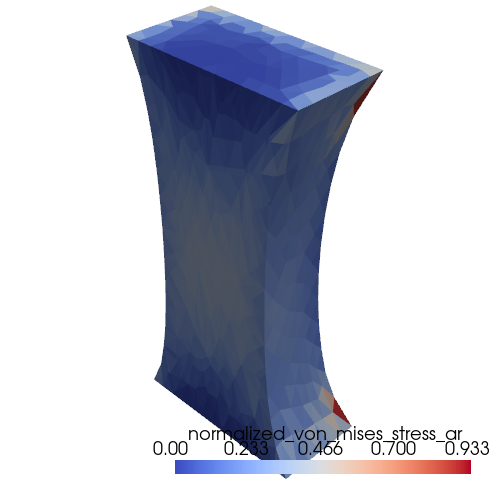

In [223]:
def convert_mesh_to_ugrid(point_ar, cell_ar):
    """
        Function that converts a mesh to a vtkUnstructuredGrid object
    """

    # Create a vtkPoints object and add the points to it
    points = vtk.vtkPoints()
    for point in point_ar:
        points.InsertNextPoint(point)

    # Create a vtkUnstructuredGrid object
    u_grid = vtk.vtkUnstructuredGrid()
    u_grid.SetPoints(points)

    # Create a vtkCellArray object and add the cells to it
    for cell in cell_ar:
        tetra = vtk.vtkTetra()
        for i, point_id in enumerate(cell):
            tetra.GetPointIds().SetId(i, point_id)
        u_grid.InsertNextCell(tetra.GetCellType(), tetra.GetPointIds())

    return u_grid

# Convert the mesh to a vtkUnstructuredGrid object
def_u_grid = convert_mesh_to_ugrid(def_point_ar, cell_ar)

# Transform the vtk_unstructured_grid to a pyvista mesh
pv_def_mesh = pv.wrap(def_u_grid)

#Plot the Von-Mises stress
pv_def_mesh.cell_data["normalized_von_mises_stress_ar"] = normalized_von_mises_stress_ar
pv_clipped_def_mesh = pv_def_mesh.clip(normal=(1, 0, 0), origin=(0.5, 0.5, 0.5)) 


# Create a plotter for Jupyter Notebooks
pv.start_xvfb()  # Needed for some environments (e.g., remote servers)
plotter = pv.Plotter(notebook=True, window_size=(500, 500))
plotter.add_mesh(pv_clipped_def_mesh, scalars="normalized_von_mises_stress_ar", cmap="coolwarm")
plotter.show()




<br>
<br>
<br>
<br>
<br>

---

## Static case 2

In this static case, we will apply a traction force on the top face of the solid. The displacament of 
the points located at the bottom of the mesh will be set to 0.

---

0.3106613022839095


/home/steve/Documents/Miscellaneous/FEM/fem_env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/home/steve/Documents/Miscellaneous/FEM/fem_env/lib/python3.10/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(
MESA-LOADER: failed to open zink: /opt/amdgpu/lib/x86_64-linux-gnu/dri/zink_dri.so: cannot open shared object file: No such file or directory (search paths /opt/amdgpu/lib/x86_64-linux-gnu/dri, suffix _dri)
failed to load driver: zink


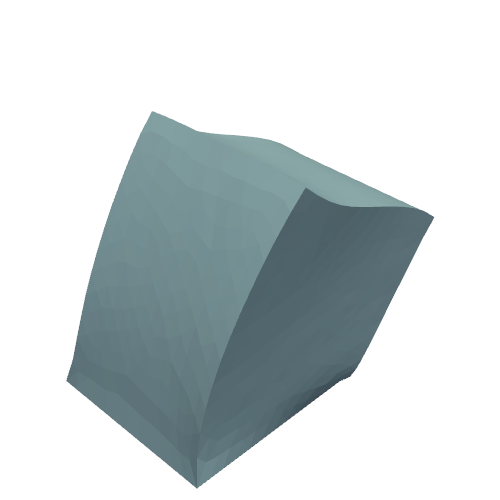

In [ ]:
# Get the faces located at the top of the mesh
top_boundary_face_ar = face_ar[top_boundary_face_mask]

# Create a traction vector that is orthogonal to the normal of the top boundary faces
global_traction_vector_ar = np.zeros((n_vertices, 3))
traction_force_amplitude = 1e3

global_traction_vector_ar[top_boundary_face_ar[:, 0], 0] = traction_force_amplitude
global_traction_vector_ar[top_boundary_face_ar[:, 1], 0] = traction_force_amplitude
global_traction_vector_ar[top_boundary_face_ar[:, 2], 0] = traction_force_amplitude
global_traction_vector_ar = global_traction_vector_ar.flatten()

# Compute the generalized traction force vector
generalized_traction_forces = global_traction_force_matrix.dot(global_traction_vector_ar)

# Set the displacement of the bottom points to (0,0,0)
extended_bottom_point_mask = np.repeat(bottom_point_mask, 3)

# Remove all the rows and columns corresponding to the bottom points from the global stiffness matrix
global_stiffness_matrix_with_BC = global_stiffness_matrix.tocsr()
global_stiffness_matrix_with_BC = global_stiffness_matrix_with_BC[~extended_bottom_point_mask, :][:, ~extended_bottom_point_mask]

#Remove the corresponding rows from the right-hand side vector
generalized_traction_forces_with_BC = generalized_traction_forces[~extended_bottom_point_mask]

# Compute the displacement field
displacement_field_ar = np.zeros(n_vertices * 3)
displacement_field_ar[~extended_bottom_point_mask] = spsolve(global_stiffness_matrix_with_BC, -generalized_traction_forces_with_BC)

print(displacement_field_ar.max())

# Compute the new point coordinates in the deformed configuration
def_point_ar = point_ar + displacement_field_ar.reshape(-1, 3)

# Convert the mesh to a vtkUnstructuredGrid object
def_u_grid = convert_mesh_to_ugrid(def_point_ar, cell_ar)

# Transform the vtk_unstructured_grid to a pyvista mesh
pv_def_mesh = pv.wrap(def_u_grid)

pv.save_meshio("deformed_mesh.vtu", pv_def_mesh)
 
 
# Create a plotter for Jupyter Notebooks
pv.start_xvfb()  # Needed for some environments (e.g., remote servers)
plotter = pv.Plotter(notebook=True, window_size=(500, 500))
plotter.add_mesh(pv_def_mesh)
plotter.show()